# *BASECODE 작성*

* 가상환경 activate 후 lightgbm 설치
* conda install -c conda-forge lightgbm

In [119]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import random
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import log_loss

## 0. **데이터 로드**
* 훈련에 필요없는 index 컬럼 삭제
#### 변수
* train : `train.csv`
* test : `test.csv`

In [120]:
# 데이터 불러오기
train = pd.read_csv('./train.csv')
train = train.drop(['index'], axis=1)

test = pd.read_csv('./test.csv')
test = test.drop(['index'], axis=1)

submit = pd.read_csv('./sample_submission.csv')

### 데이터 전처리
http://www.dodomira.com/2016/10/20/how_to_eda/ 

링크 참고 

## 1. **데이터 셋 확인**

* 이전 EDA 코드 돌려봤기에 코드를 직접 합치지는 않았음

#### object 8개, int64 7개 , float64 4개 있음.
-------------------------

## 2. **결측치 처리**
* 결측치는 직업 유형에만 존재함 -> 'unfilled'로 대체함. 
* 향후 '직업 유형의 결측치를 어떻게 해결할 것 인가' 고민이 필요함.

In [ ]:
test['occyp_type'].count

In [ ]:
test['occyp_type'].isnull().sum()

In [121]:
# 결측치 확인
print('훈련데이터 결측치 합 \n', train.isnull().sum())
print('테스트데이터 결측치 합 \n', test.isnull().sum())

훈련데이터 결측치 합 
 gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64
테스트데이터 결측치 합 
 gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       3152
family_size         0
begin_month         0
dtype: int64


In [ ]:
# 결측치 처리
print()
train['occyp_type'].fillna('unfilled', inplace=True) # 직업 유형 경우, 결측치가 많아서 따로 'unfilled' 라고 채움
test['occyp_type'].fillna('unfilled', inplace=True)
train.fillna('NAN', inplace=True) 
test.fillna('NAN', inplace=True)

# 확인
print('훈련데이터 결측치 합 \n', train.isnull().sum())
print('테스트데이터 결측치 합 \n', test.isnull().sum())

In [122]:
# 결측치 처리 - Retired / NAN으로 나누어 채우기
cond = (train['income_type'] == 'Pensioner')
train['occyp_type'] = train['occyp_type'].fillna(cond.map({True:'Retired', False: 'NaN'}))
train[(train['occyp_type'] == 'Retired')].count()

cond1 = (test['income_type'] == 'Pensioner')
test['occyp_type'] = test['occyp_type'].fillna(cond1.map({True:'Retired', False: 'NaN'}))
test[(test['occyp_type'] == 'Retired')].count()

# 확인
print('훈련데이터 결측치 합 \n', train.isnull().sum())
print('테스트데이터 결측치 합 \n', test.isnull().sum())

훈련데이터 결측치 합 
 gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
credit           0
dtype: int64
테스트데이터 결측치 합 
 gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
dtype: int64


## 3. **이상치 처리**
* 정수형, 실수형 데이터에서 이상치 찾아보고, 그에 맞게 처리하자.

### **3-1. 각 컬럼 데이터 변환 and 이상치 처리**
* 정수/실수형 데이터를 가진 10개 컬럼 중 휴대전화/직장전화/가정용전화/이메일 보유여부는 이상치 없음. (1아니면 0이니깐)
* 이 외에 6개 컬럼들 하나씩 살펴보기
 * 6개: 자녀 수, 가족 규모, 연간 소득, 출생일, 업무 시작일, 신용카드 발급 월 
 * 또한 분석하기 용이하게 데이터 변경 (ex) 부호 변환 or 일 수를 나이로)

#### 1) 자녀 수
* 6명 이상의 자녀를 가진 사람은 5명으로 변경 -> 이유: test set에서 자녀의 수 max가 5 이기 때문. 

childnum unique: [0 1 2 3 4 5]


<AxesSubplot:xlabel='child_num'>

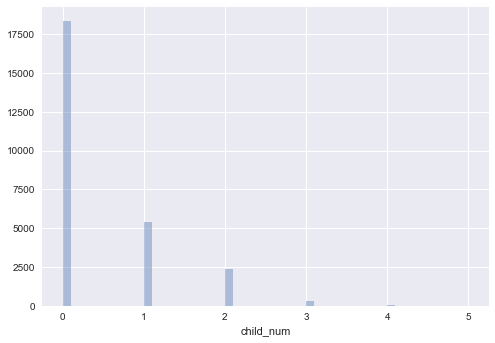

In [133]:
# 아이가 6명 이상인 데이터는 5로 변경
train.loc[train['child_num'] >= 6,'child_num']=5
print('childnum unique:', train['child_num'].unique())
sns.distplot(train['child_num'], kde=False, label='child_num')

childnum unique: [0 1 2 3 4]


<AxesSubplot:xlabel='child_num'>

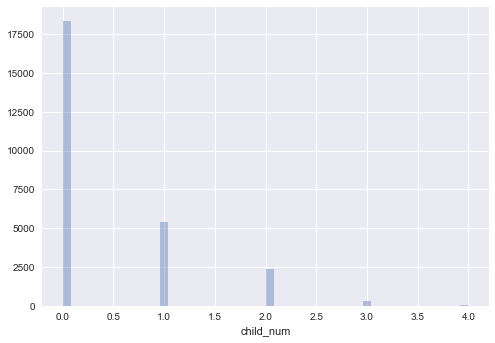

In [143]:
# 아이가 5명 이상인 데이터는 4로 변경
train.loc[train['child_num'] >= 5,'child_num']=4
print('childnum unique:', train['child_num'].unique())
sns.distplot(train['child_num'], kde=False, label='child_num')

childnum unique: [0 1 2 3]


<AxesSubplot:xlabel='child_num'>

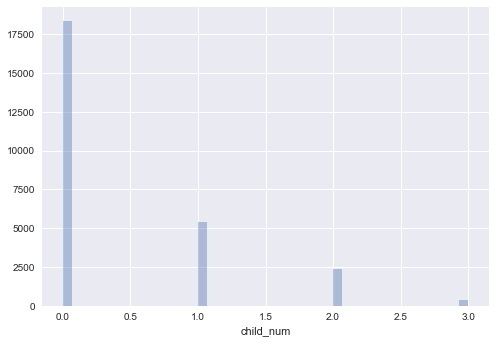

In [152]:
# 아이가 4명 이상인 데이터는 3로 변경
train.loc[train['child_num'] >= 4,'child_num']=3
print('childnum unique:', train['child_num'].unique())
sns.distplot(train['child_num'], kde=False, label='child_num')

In [ ]:
# 아이가 3명 이상인 데이터는 2로 변경
train.loc[train['child_num'] >= 3,'child_num']=2
print('childnum unique:', train['child_num'].unique())
sns.distplot(train['child_num'], kde=False, label='child_num')

#### 2) 가족 규모
* 1의 이유와 같이 최대 아이 숫자를 5로 했기 때문에 가족 규모의 최댓값도 7로 변경함

In [134]:
train.loc[train['family_size'] >= 8,'family_size']=7

In [144]:
# 가족 규모의 최댓값도 6으로 변경
train.loc[train['family_size'] >= 7,'family_size']=6

In [153]:
# 가족 규모의 최댓값도 5으로 변경
train.loc[train['family_size'] >= 6,'family_size']=5

In [ ]:
# 가족 규모의 최댓값도 4으로 변경
train.loc[train['family_size'] >= 5,'family_size']=4

In [ ]:
print('train familysize unique:', train['family_size'].unique())
sns.distplot(train['family_size'], kde=False, label='family_size')

#### 3) 연간 소득
* 테스트 데이터에서도 박스플롯 밖의 값이 많이 있기에 박스플롯 밖의 값 제거 안하기로 결정

#### 4) 출생일 -> 나이
* 양수 변환 후 나이로 변환
* 정수형으로 변환

In [123]:
def days_to_age(x):
    return (x*-1)/365

# train
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].apply(days_to_age)
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].astype({'DAYS_BIRTH':'int'})
display(train['DAYS_BIRTH'])

# test
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].apply(days_to_age)
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].astype({'DAYS_BIRTH':'int'})
display(test['DAYS_BIRTH'])

0        38
1        31
2        52
3        41
4        41
         ..
26452    33
26453    41
26454    27
26455    27
26456    53
Name: DAYS_BIRTH, Length: 26457, dtype: int32

0       60
1       51
2       43
3       52
4       48
        ..
9995    50
9996    29
9997    57
9998    45
9999    25
Name: DAYS_BIRTH, Length: 10000, dtype: int32

#### 5) 업무시작일 -> 업무 연차
* 양수 변환 후 연차로 변환
    * 단, 365243은 0연차로 변환
    * 135일 일한 사람과 0연차를 구분하기 위해서 0연차를 제외하고 모두 +1 해줌
* 정수형으로 변환

In [124]:
def days_to_year(x):
    if x==365243 :
        return 0
    return (x*-1)/365+1

# train
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(days_to_year)
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].astype({'DAYS_EMPLOYED':'int'})
display(train['DAYS_EMPLOYED'])

# test
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(days_to_year)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].astype({'DAYS_EMPLOYED':'int'})
display(test['DAYS_EMPLOYED'])

0        13
1         5
2        13
3         6
4         6
         ..
26452     6
26453     7
26454     6
26455     1
26456     3
Name: DAYS_EMPLOYED, Length: 26457, dtype: int32

0        0
1       24
2        1
3        7
4       26
        ..
9995    15
9996     4
9997    39
9998     3
9999     1
Name: DAYS_EMPLOYED, Length: 10000, dtype: int32

#### 6) 신용카드 발급 월

* 양수로 변환

In [125]:
def minus(x):
    return x * -1

# train
train['begin_month'] = train['begin_month'].apply(minus)
display(train['begin_month'])

# test
test['begin_month'] = test['begin_month'].apply(minus)
display(test['begin_month'])

0         6
1         5
2        22
3        37
4        26
         ..
26452     2
26453    47
26454    25
26455    59
26456     9
Name: begin_month, Length: 26457, dtype: int64

0       60.0
1       36.0
2       40.0
3       41.0
4        8.0
        ... 
9995    19.0
9996    34.0
9997    55.0
9998    33.0
9999    11.0
Name: begin_month, Length: 10000, dtype: float64

#### 7) 박스 플롯을 통한 이상치 확인
* 박스플롯

#### 8) 상관관계
* 범주형과 수치형 상관관계 확인 - https://dodonam.tistory.com/217

## 4. **Feature Engineering** - 여기에 정규화 포함시켜야 할듯요!

* 수치형 컬럼은 기존 데이터 분포와 비슷하고, 어느정도 일정한 범위를 갖게 정규화해야함
* 각 컬럼마다 동일한 스케일러 적용할 필요는 없음. 
* [다른 스케일러 적용한 사례- 블로그](https://lsjsj92.tistory.com/555?category=853217)

### 4-1. 범주형 데이터 one-hot encoding, label encoding
* object (범주형)은 원핫인코딩 하기.
    * 단, occyp_type은 라벨 인코딩.
* 범주형 데이터를 가지는 변수 확인 (dtype가 object)
* gender(2), car(2), reality(2), income_type(5), edu_type(5), family_type(5), house_type(6), occyp_type(18)

In [154]:
# object 객체를 가지는 변수(열) 확인
object_col = []
for col in train.columns:
    if train[col].dtype == 'object' : # and col!='occyp_type': # 변수가 18개인 occyp_type만 제외
        object_col.append(col)
display(object_col)

[]

#### 4-1-1. train의 원핫인코딩, 라벨인코딩

In [155]:
# occyp_type을 제외한 모든 object객체 열을 onehot encoding

enc = OneHotEncoder()
enc.fit(train.loc[:,object_col])

train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
train.drop(object_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)

#### 4-1-2. test의 원핫인코딩, 라벨인코딩

### 4-2. 데이터 정규화

#### 정규화 전 분포도
* 수치형 데이터만

#### 4-2-1. MinMaxScaler

In [156]:
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler_data = train[train.columns.difference(['credit'])].copy()

minMaxScaler = MinMaxScaler()
print(minMaxScaler.fit(MinMaxScaler_data))
train_data_minMaxScaled = minMaxScaler.transform(MinMaxScaler_data)

# MinMaxScaler_data - MinMaxScaler적용한 데이터 프레임
index = 0
for col in MinMaxScaler_data.columns :
    MinMaxScaler_data[col] = train_data_minMaxScaled[:,index]
    index = index + 1
display(MinMaxScaler_data)

MinMaxScaler()


,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,begin_month,car_N,car_Y,child_num,edu_type_Academic degree,edu_type_Higher education,edu_type_Incomplete higher,...,occyp_type_Realty agents,occyp_type_Retired,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,phone,reality_N,reality_Y,work_phone
0,0.361702,0.295455,0.0,0.100000,1.0,0.0,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.212766,0.113636,0.0,0.083333,1.0,0.0,0.333333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.659574,0.295455,0.0,0.366667,0.0,1.0,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.425532,0.136364,0.0,0.616667,1.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.425532,0.136364,0.0,0.433333,0.0,1.0,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0.255319,0.136364,0.0,0.033333,1.0,0.0,0.666667,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26453,0.425532,0.159091,0.0,0.783333,1.0,0.0,0.333333,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
26454,0.127660,0.136364,0.0,0.416667,0.0,1.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26455,0.127660,0.022727,0.0,0.983333,1.0,0.0,0.000000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


-----------------------------------------------
## 여기까지 정규화, 이상치 처리 완료해야 함, 데이터 전처리 단계

#### 정규화한 데이터 이름
* MinMaxScaler_data
* MaxAbsScaler_data
* StandardScaler_data
* RobustScaler_data

## 5. 모델링

### 5-0 데이터 분리
* 데이터 분리는 stratifiedKFold를 사용하여 y값 분포를 비슷하게 분리 시킴 -> 5-fold
    * StratifiedKFold(계층별 k-겹 교차검증) - 불균형한 분포도를 가진 레이블 데이터를 위한 방식, 특정 레이블 값이 너무 많거나 적은 경우
    * 타겟에 속성값의 개수를 동일하게 가져감으로써 kfold 같이 데이터가 한곳으로 몰리는 것을 방지
    * 대부분의 경우 회귀에서는 k-겹 교차 검증, 분류에서는 계층별 k-겹 교차검증의 기본값이 잘 작동함
* n_split는 몇 개로 분할할지 결정
* shtffle은 데이터 섞어서 샘플의 순서 랜덤하게. 
* 데이터를 섞을 때 random_state를 고정해서 똑같은 작업을 재현할 수있음
* 그렇지 않으면 cross_val_score를 실행할 때마다 폴드가 바뀌어 매번 결과가 달라짐

In [157]:
# 설명변수 X, 예측변수 y 할당 (사용하고자하는 정규화 스케일러로 변경 가능)
X = MinMaxScaler_data
Y = train['credit']

In [158]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
folds=[]

# 계층별 k-겹 교차검증을 위해 인덱스를 나누는 코드
for train_index, valid_index in skf.split(X, Y):
    folds.append((train_index, valid_index))
display(folds)

[(array([    0,     1,     3, ..., 26453, 26454, 26456]),
  array([    2,    26,    45, ..., 26446, 26452, 26455])),
 (array([    2,     3,     6, ..., 26454, 26455, 26456]),
  array([    0,     1,     4, ..., 26435, 26447, 26450])),
 (array([    0,     1,     2, ..., 26453, 26454, 26455]),
  array([    3,    12,    16, ..., 26438, 26448, 26456])),
 (array([    0,     1,     2, ..., 26454, 26455, 26456]),
  array([    6,    14,    29, ..., 26440, 26442, 26453])),
 (array([    0,     1,     2, ..., 26453, 26455, 26456]),
  array([    7,     9,    10, ..., 26449, 26451, 26454]))]

* 여기서 앞으로 계속 사용할 X,Y, folds 저장되어 있음

### 5-1. LGBM
[LGBM 모델 설명](https://lsjsj92.tistory.com/548)
#### Training    
* LGBM의 기본 파라미터로 훈련
* 30번 이상 개선 없을 경우 중단.
* 각 5개의 fold를 훈련하여 저장

In [159]:
random.seed(42)
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # LGBM 모델 돌리기, 
    # 30번 이상 개선 없을 시 중단, 5개의 fold를 훈련하여 저장
    lgb = LGBMClassifier(n_estimators=1000)
    lgb.fit(X_train, Y_train, 
            eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
            early_stopping_rounds=30,
           verbose=100)
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')

====================================1============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.662713	valid_1's multi_logloss: 0.758952
[200]	training's multi_logloss: 0.581757	valid_1's multi_logloss: 0.745026
[300]	training's multi_logloss: 0.52151	valid_1's multi_logloss: 0.73977
Early stopping, best iteration is:
[301]	training's multi_logloss: 0.521066	valid_1's multi_logloss: 0.739657


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.661765	valid_1's multi_logloss: 0.770789
[200]	training's multi_logloss: 0.578846	valid_1's multi_logloss: 0.760218
[300]	training's multi_logloss: 0.516949	valid_1's multi_logloss: 0.755942
Early stopping, best iteration is:
[308]	training's multi_logloss: 0.51176	valid_1's multi_logloss: 0.755008


====================================3======

#### Test inference
* 각 폴드를 훈련시킨 LGBM으로 예측
* 해당 대회는 logloss score를 겨루는 것이기 때문에 각 class의 probability를 얻어야함
* 대부분의 머신러닝 모델에서 predict, predict_proba를 구분하여 사용함.
* predict는 class 출력을 해주고 predict_proba는 class 별 probability를 출력해줌
* predict_proba를 사용하여 예측한 것을 5-fold 더하여 평균내어 앙상블함

### 5-2. **로지스틱 회귀분석**

In [151]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

random.seed(42)
logR_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # 로지스틱 회귀
    logmodel = LogisticRegression()
    logmodel.fit(X_train, Y_train)
    print(f'Log Loss: {log_loss(Y_valid, logmodel.predict_proba(X_valid)):.6f}')
    logR_models[fold]=logmodel
    print('학습용 데이터셋 정확도 : %.5f' % logmodel.score(X_train, Y_train))
    print('검증용 데이터셋 정확도 : %.5f' % logmodel.score(X_valid, Y_valid))
#     print('컬럼의 계수 확인 : ', logmodel.coef_)
    print(f'================================================================================\n\n')

====================================1============================================
Log Loss: 0.867011
학습용 데이터셋 정확도 : 0.64356
검증용 데이터셋 정확도 : 0.64324


====================================2============================================
Log Loss: 0.863637
학습용 데이터셋 정확도 : 0.64328
검증용 데이터셋 정확도 : 0.64324


====================================3============================================
Log Loss: 0.859671
학습용 데이터셋 정확도 : 0.64297
검증용 데이터셋 정확도 : 0.64279


====================================4============================================
Log Loss: 0.867006
학습용 데이터셋 정확도 : 0.64325
검증용 데이터셋 정확도 : 0.64260


====================================5============================================
Log Loss: 0.857805
학습용 데이터셋 정확도 : 0.64287
검증용 데이터셋 정확도 : 0.64298


